In [1]:
# If Colab packages are outdated, uncomment to upgrade:
# !pip install -U pandas scikit-learn matplotlib openpyxl

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, confusion_matrix
)

np.random.seed(42)



In [3]:
# Option A: manual upload in Colab file panel or via files.upload()
# from google.colab import files
# uploaded = files.upload()   # choose Newspapers_merged_sorted.xlsx
# DATA_PATH = "Newspapers_merged_sorted.xlsx"

# Option B: mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = "/content/drive/MyDrive/your_folder/Newspapers_merged_sorted.xlsx"

# If the Excel is already in the working directory, use:
DATA_PATH = "Newspapers_merged_sorted.xlsx"

df = pd.read_excel(DATA_PATH)   # requires openpyxl
print("Shape:", df.shape)
print(df.columns.tolist())
df.head(3)


Shape: (20177, 10)
['Title', 'Author', 'Newspaper Title', 'Time', '藏馆', '馆藏索取号', '分类号', 'SourceFile', 'FileNumber', 'RowInFile']


,Title,Author,Newspaper Title,Time,藏馆,馆藏索取号,分类号,SourceFile,FileNumber,RowInFile
0,野史氏辨狱丛谈,逸民,民立报,1911-01-11,NaN,NaN,NaN,Newspaper/1.txt,1,1
1,政党组织之必要,佩,绍兴公报,1911-01-17,NaN,NaN,NaN,Newspaper/1.txt,1,2
2,论大隈伯对待淸国谈之谬妄（续昨）,因,绍兴公报,1911-01-20,NaN,NaN,NaN,Newspaper/1.txt,1,3


In [4]:
# Set expected column names (edit if your file differs)
TITLE_COL = "Title"
PAPER_COL = "Newspaper Title"
TIME_COL  = "Time" if "Time" in df.columns else None

assert TITLE_COL in df.columns, "Cannot find Title column"
if PAPER_COL not in df.columns:
    PAPER_COL = None

df[TITLE_COL] = df[TITLE_COL].astype(str).str.strip()
print("Sample titles:")
for t in df[TITLE_COL].head(5).tolist():
    print(" -", t)


Sample titles:
 - 野史氏辨狱丛谈
 - 政党组织之必要
 - 论大隈伯对待淸国谈之谬妄（续昨）
 - 学部注最小学教育
 - 幸未成灾


In [5]:
# Target: whether the title explicitly contains the feminine pronoun "她"
df["_explicit_ta"] = df[TITLE_COL].str.contains("她", regex=False).astype(int)
pos_rate = df["_explicit_ta"].mean()
print(f"Positive share (has '她'): {pos_rate:.4%} | n={len(df)}")

# Avoid leakage: remove "她/她们" from the title before feature extraction
df["_title_masked"] = (df[TITLE_COL]
                       .str.replace("她们", " ", regex=False)
                       .str.replace("她", " ", regex=False))


Positive share (has '她'): 0.9218% | n=20177


In [6]:
def parse_year(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r"(18|19|20)\d{2}", s)  # find a 4-digit year
    if m:
        return int(m.group(0))
    try:
        dt = pd.to_datetime(s, errors="coerce")
        return dt.year if pd.notna(dt) else np.nan
    except:
        return np.nan

df["_year"] = df[TIME_COL].apply(parse_year) if TIME_COL is not None else np.nan

# Periodization bins (edit to match your design)
bins   = [-np.inf, 1919, 1924, 1929, 1933, 1937, np.inf]
labels = ["<=1919","1920-24","1925-29","1930-33","1934-37",">=1938"]
df["_year_bin"] = pd.cut(df["_year"], bins=bins, labels=labels)
df[["_year", "_year_bin"]].head(5)


,_year,_year_bin
0,1911,<=1919
1,1911,<=1919
2,1911,<=1919
3,1911,<=1919
4,1911,<=1919


In [7]:
# Group by year to reduce temporal leakage
groups = df["_year"].fillna(-1).astype(int)
y = df["_explicit_ta"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, y, groups=groups))

train = df.iloc[train_idx].copy()
test  = df.iloc[test_idx].copy()
y_train = y[train_idx]
y_test  = y[test_idx]

len(train), len(test), y_train.mean(), y_test.mean()


(15456, 4721, np.float64(0.009381469979296066), np.float64(0.0086846007201864))

In [8]:
# Character 2–3-gram TF-IDF works well for Chinese without tokenization
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(2,3),
    min_df=10,          # increase for speed; decrease if data is small
    max_features=60000
)

feature_cols = [("title_tfidf", tfidf, "_title_masked")]
if PAPER_COL is not None:
    feature_cols.append(("paper_ohe", OneHotEncoder(handle_unknown="ignore"), [PAPER_COL]))
feature_cols.append(("year_ohe", OneHotEncoder(handle_unknown="ignore"), ["_year_bin"]))

preprocessor = ColumnTransformer(
    feature_cols,
    remainder="drop",
    sparse_threshold=0.3
)
preprocessor


ColumnTransformer(transformers=[('title_tfidf',
                                 TfidfVectorizer(analyzer='char',
                                                 max_features=60000, min_df=10,
                                                 ngram_range=(2, 3)),
                                 '_title_masked'),
                                ('paper_ohe',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Newspaper Title']),
                                ('year_ohe',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['_year_bin'])])

In [9]:
# Class imbalance is severe; use class_weight='balanced' where applicable
clf_logreg = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(solver="saga", class_weight="balanced", max_iter=300))
])

clf_svm = Pipeline([
    ("pre", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

clf_nb = Pipeline([
    ("pre", preprocessor),
    ("clf", ComplementNB(alpha=0.5))
])

models = {
    "LogisticRegression_saga": clf_logreg,
    "LinearSVC": clf_svm,
    "ComplementNB": clf_nb
}
list(models.keys())


['LogisticRegression_saga', 'LinearSVC', 'ComplementNB']

In [10]:
perf_rows = []
roc_curves = {}

for name, pipe in models.items():
    print(f"Training {name} …")
    pipe.fit(train, y_train)

    # Get continuous scores for metrics and curves
    if hasattr(pipe, "predict_proba"):
        scores = pipe.predict_proba(test)[:, 1]
        thr = 0.5
    elif hasattr(pipe, "decision_function"):
        scores = pipe.decision_function(test)
        thr = 0.0
    elif hasattr(pipe, "predict_log_proba"):
        scores = pipe.predict_log_proba(test)[:, 1]
        thr = 0.5
    else:
        scores = pipe.predict(test).astype(float)
        thr = 0.5

    preds = (scores >= thr).astype(int)
    acc  = accuracy_score(y_test, preds)
    f1m  = f1_score(y_test, preds, average="macro")
    auc  = roc_auc_score(y_test, scores)

    perf_rows.append({"Model": name, "Accuracy": acc, "MacroF1": f1m, "ROC_AUC": auc})
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_curves[name] = (fpr, tpr)

perf = pd.DataFrame(perf_rows).sort_values("MacroF1", ascending=False).reset_index(drop=True)
perf


Training LogisticRegression_saga …
Training LinearSVC …
Training ComplementNB …


,Model,Accuracy,MacroF1,ROC_AUC
0,ComplementNB,0.979242,0.605851,0.783612
1,LinearSVC,0.935819,0.551711,0.875581
2,LogisticRegression_saga,0.483584,0.337141,0.801738


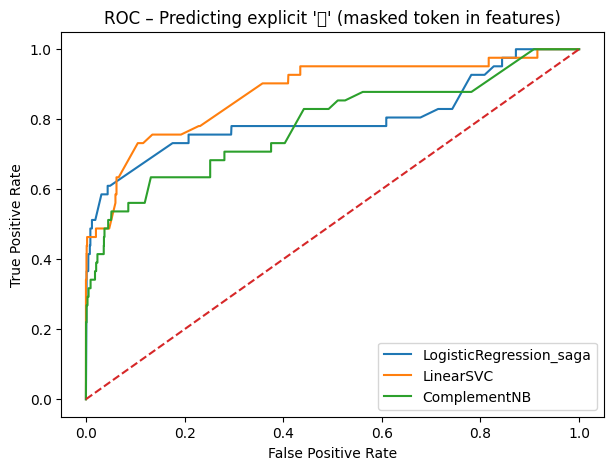

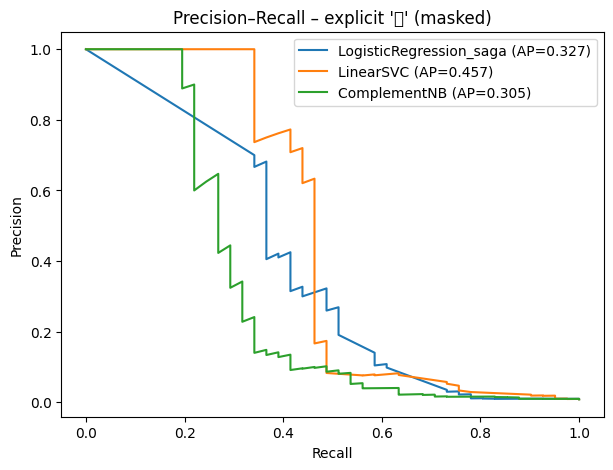

In [11]:
# ROC
plt.figure(figsize=(7,5))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Predicting explicit '她' (masked token in features)")
plt.legend()
plt.show()

# PR
plt.figure(figsize=(7,5))
for name, pipe in models.items():
    if hasattr(pipe, "predict_proba"):
        s = pipe.predict_proba(test)[:,1]
    elif hasattr(pipe, "decision_function"):
        s = pipe.decision_function(test)
    elif hasattr(pipe, "predict_log_proba"):
        s = pipe.predict_log_proba(test)[:,1]
    else:
        s = pipe.predict(test).astype(float)
    p, r, _ = precision_recall_curve(y_test, s)
    ap = average_precision_score(y_test, s)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall – explicit '她' (masked)")
plt.legend()
plt.show()


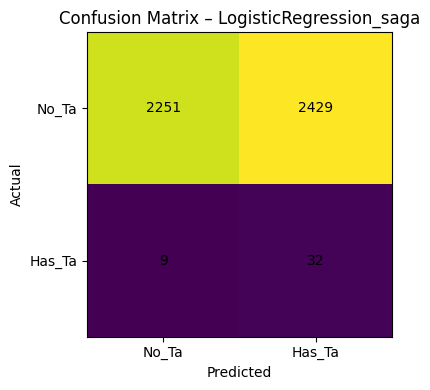

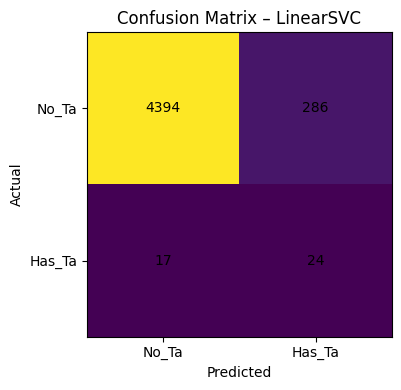

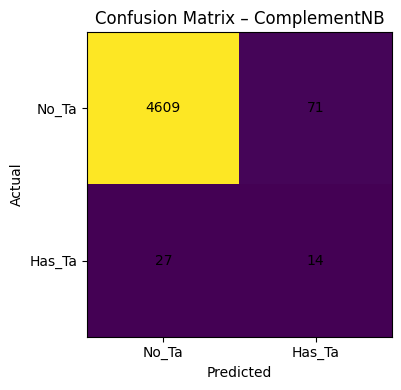

In [12]:
def plot_cm(y_true, scores, name):
    thr = 0.0 if scores.min() < 0 else 0.5
    preds = (scores >= thr).astype(int)
    cm = confusion_matrix(y_true, preds, labels=[0,1])
    fig = plt.figure(figsize=(4.5,4))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation="nearest")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["No_Ta","Has_Ta"])
    ax.set_yticklabels(["No_Ta","Has_Ta"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    ax.set_title(f"Confusion Matrix – {name}")
    fig.tight_layout()
    plt.show()

for name, pipe in models.items():
    if hasattr(pipe, "predict_proba"):
        s = pipe.predict_proba(test)[:,1]
    elif hasattr(pipe, "decision_function"):
        s = pipe.decision_function(test)
    elif hasattr(pipe, "predict_log_proba"):
        s = pipe.predict_log_proba(test)[:,1]
    else:
        s = pipe.predict(test).astype(float)
    plot_cm(y_test, s, name)


In [13]:
# Create a validation split inside the training set (grouped by year)
sub_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
sub_tr_idx, sub_va_idx = next(sub_gss.split(train, y_train, groups=train["_year"].fillna(-1)))
sub_tr, sub_va = train.iloc[sub_tr_idx], train.iloc[sub_va_idx]
y_tr, y_va = y_train[sub_tr_idx], y_train[sub_va_idx]

svm_tune = models["LinearSVC"]
svm_tune.fit(sub_tr, y_tr)

scores_va = (svm_tune.decision_function(sub_va)
             if hasattr(svm_tune,"decision_function")
             else svm_tune.predict_proba(sub_va)[:,1])

# Search a threshold that maximizes macro-F1 on validation
thr_list = np.linspace(scores_va.min(), scores_va.max(), 101)
best = (-1, 0.0)  # (F1, thr)
for thr in thr_list:
    preds = (scores_va >= thr).astype(int)
    f1m = f1_score(y_va, preds, average="macro")
    if f1m > best[0]:
        best = (f1m, thr)
print("Best macro-F1 on validation:", best)

# Re-evaluate on the held-out test set using the tuned threshold
scores_te = (svm_tune.decision_function(test)
             if hasattr(svm_tune,"decision_function")
             else svm_tune.predict_proba(test)[:,1])
preds_te = (scores_te >= best[1]).astype(int)
print("Test macro-F1 with tuned threshold:",
      f1_score(y_test, preds_te, average="macro"))


Best macro-F1 on validation: (0.724350449600907, np.float64(0.5499395992772049))
Test macro-F1 with tuned threshold: 0.7073661276559827
